Scratch Jupyter Noteboook

In [151]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from matplotlib import cm
import tqdm  
import activations
import params
import inference
import training
%matplotlib inline
from importlib import reload


# Parameters

In [177]:

import activations
from params import FlattenOrder

nonlinear_params = {
    'alpha': 900,
    'beta':  -.06045,
    'r': 3.99,
    'mu': 1.99
}

num_samples_train = 10000
num_samples_test = 1000


config = params.RegressionParams(
    width = 1000,
    depth = 50,
    input_dimension = 2,
    transform_type = activations.TransformType.TENT,
    transform_params = params.TentParams(
        mu = 1.99
    ), 
    output_dimension=1,
    flatten_order=FlattenOrder.AUTO
)

# Function Definitions

In [178]:

def xor(x: NDArray) -> int:

    if x[0] >= 0:
        # First or Fourth Quadrants
        if x[1] >= 0:
            # First Quadrant
                return 0
            # Fourth Quadrant
        else:
            return 1
        
    # Second or Third Quadrants
    else:
        # Second Quadrant
        if x[1] >= 0:
            return 1
        
        # Fourth Quadrant
        else:
            return 0

# Neuron Preferred Directions

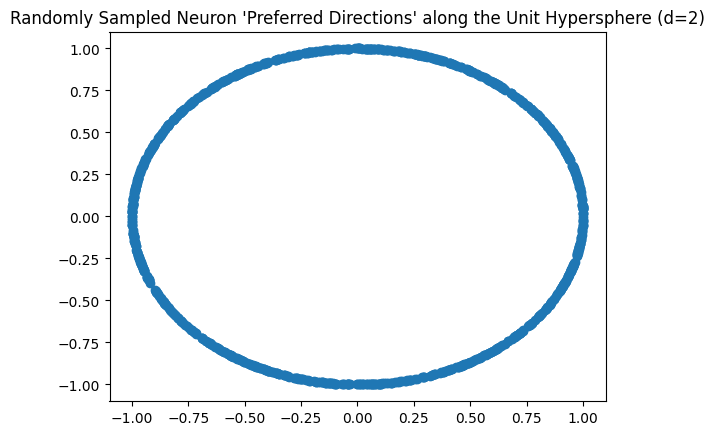

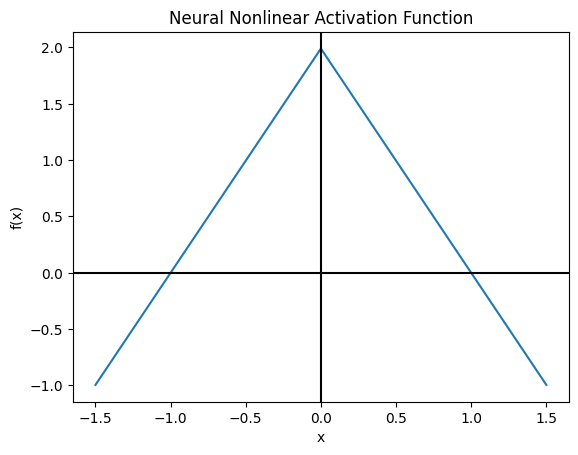

In [179]:
neurons = np.random.normal(loc=0, scale=1, size=(config.input_dimension, config.width))
neurons = neurons / np.linalg.norm(neurons, axis=0)
neurons = np.asarray(neurons)
plt.scatter(neurons[0,:], neurons[1,:])
plt.title("Randomly Sampled Neuron 'Preferred Directions' along the Unit Hypersphere (d=2)")
plt.show()

plt.title("Neural Nonlinear Activation Function")
xs = np.asarray(np.linspace(-1.5, 1.5, num=1000))
# plt.plot(xs, gauss(xs, alpha=nonlinear_params['alpha'], beta=nonlinear_params['beta']))
plt.plot(xs, activations.tent(xs, params=config.transform_params))

# plt.xlim([-1, 1])
# plt.ylim(-1,1)
plt.xlabel("x")
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.ylabel("f(x)")
plt.show()


# Topological Mixing

/tmp/ipykernel_109259/1203728560.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('inferno', config.depth+1)
/tmp/ipykernel_109259/1203728560.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(activations_identity[idx_layer, :, 0], activations_identity[idx_layer, :, 1], label=f"Pass {idx_layer+1}", c=colors(idx_layer+1))


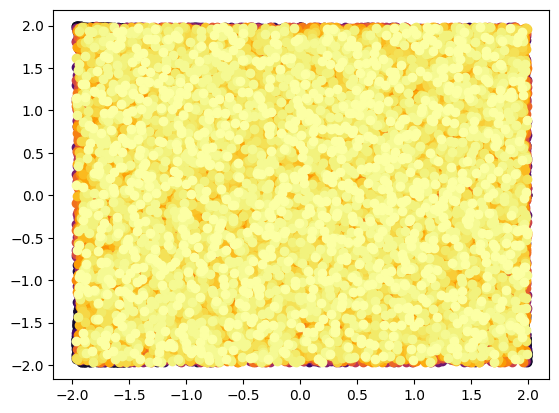

In [155]:
colors = cm.get_cmap('inferno', config.depth+1)


activations_identity = activations.compute_activations(neurons, np.asarray(np.eye(2)), config)


plt.scatter(neurons[0,:], neurons[1,:], color="black")
for idx_layer in range(1,config.depth): 
    plt.scatter(activations_identity[idx_layer, :, 0], activations_identity[idx_layer, :, 1], label=f"Pass {idx_layer+1}", c=colors(idx_layer+1))
    
# plt.xlim([-1.25, 1.25])
# plt.ylim([-1.25, 1.25])
# plt.legend()
plt.show()

# XOR Example 

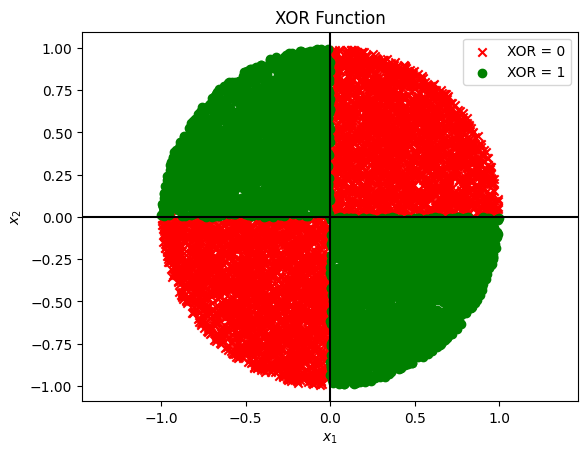

In [156]:



# acts has shape (depth, num_neurons, num_samples)
test_samples = np.random.normal(loc=0, scale=1, size=(config.input_dimension, num_samples_test))
test_samples /= np.linalg.norm(test_samples,axis=0)
train_samples = np.random.normal(loc=0, scale=1, size=(config.input_dimension, num_samples_train))
train_samples /= np.linalg.norm(train_samples,axis=0)

# Scale by radii distributed according to d^th root (where d is dimension) to get uniform density 
test_radii = np.random.uniform(0, 1, size=num_samples_test)
train_radii = np.random.uniform(0, 1, size=num_samples_train)
test_samples *= np.sqrt(test_radii)
train_samples *= np.sqrt(train_radii)


# Batch compute activations
activations_train = activations.compute_activations(neurons, input_x=train_samples, config=config) # np.zeros((n_layers, num_neurons, num_samples_train)) 
activations_test =  activations.compute_activations(neurons, input_x=test_samples, config=config) # np.zeros((n_layers, num_neurons, num_samples_train)) 


# Compute XOR, then use making to plot classification
xors_train = np.expand_dims(np.array([xor(train_samples[:, i]) for i in range(num_samples_train)]), axis=-1)

mask_0 = (xors_train == 0).squeeze()
mask_1 = (xors_train == 1).squeeze()
plt.scatter(train_samples[0,mask_0], train_samples[1,mask_0], c='red', marker='x', label='XOR = 0')
plt.scatter(train_samples[0,mask_1], train_samples[1,mask_1], c='green', marker='o', label='XOR = 1')
        
plt.axis('equal')
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

plt.title("XOR Function")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

    

# Train an XOR Decoder

In [210]:
activations_train.shape, num_samples_train
xors_train.shape

(10000, 1)

In [212]:
# acts has shape (depth, num_neurons, num_samples)
# reload(training)
# decoder = training.compute_decoder(activations_train, np.expand_dims(xors_train, axis=0), config)
# xors_recovered = (decoder @ training.flatten_depth_width(activations_train, config)).T

import multiprocessing as mp
import os 

def regress_neuron(acts: NDArray[np.floating], target_outputs: NDArray[np.floating]) -> NDArray[np.floating]:
    """Regress a given neuron's activations onto the provided target output. 

    Args:
        acts (NDArray[np.floating]): The neuron's activations for the provied sample data, having shape [NUM_SAMPLES] x [DEPTH]
        target_outputs (NDArray[np.floating]): The target outputs the neuron should be mapped to having shape [NUM_SAMPLES] x [OUTPUT_DIM]

    Returns:
        NDArray[np.floating]: The regression coefficients that map the neuron's output to target output having shape [DEPTH] x [OUTPUT_DIM]
    """
    # assumed that input is already sanity checked 
    # TODO: sanity checking 
    return np.linalg.lstsq(acts, target_outputs, rcond=None)[0]

# lets start by storing all neuron decoders in memory, then work towards accumulation of completed regressions for a final decoder. 
# We can use an average update formula for the accumulation to iteratively reweight new sums. 

def compute_decoders(activations: NDArray[np.floating], target_output: NDArray[np.floating], config: params.RegressionParams) -> NDArray[np.floating]:
    """Compute the decoders that map activations associated with target input to the target output

    Args:
        activations (NDArray[np.floating]): Activations associated with target input having shape [DEPTH] x [WIDTH] x [NUM_SAMPLES]
        target_output (NDArray[np.floating]): The target output to regress against, having shape [NUM_SAMPLES] x [OUTPUT_DIMENSION]
        config (params.RegressionParams): The regression configuration specifying, width, and depth. 

    Returns:
        NDArray[np.floating]: _description_
    """
    cpu_count = mp.cpu_count() 
    if len(os.sched_getaffinity(0)) < cpu_count:
        try:
            os.sched_setaffinity(0, range(cpu_count))
        except OSError:
            print('Could not set affinity')
    num_worker_procs = len(os.sched_getaffinity(0))

    with mp.Pool(num_worker_procs) as p:
        decoders = np.stack(
            *[
                p.starmap(
                    func=regress_neuron,
                    iterable=tqdm.tqdm(
                        [
                            (
                                activations[:, idx_neuron, :].T, 
                                target_output,
                            )
                            for idx_neuron in range(config.width)
                        ],
                        total=config.width
                    )
                )  
            ],
            axis=-1
        )
    return decoders

decoders = compute_decoders(activations_train, xors_train, config)

100%|██████████| 1000/1000 [00:11<00:00, 87.44it/s]


100%|██████████| 1000/1000 [00:09<00:00, 102.85it/s]


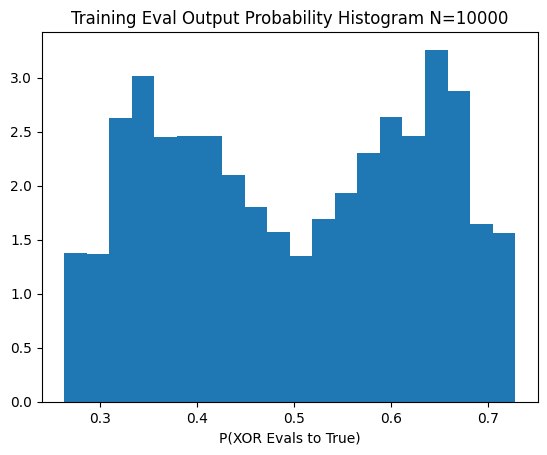

In [213]:

def infer(input_x: NDArray[np.floating], neurons: NDArray[np.floating],  decoders: NDArray[np.floating], config: params.RegressionParams) -> NDArray[np.floating]:
    """Pass input through the model and infer the output

    Args:
        input_x (NDArray[np.floating]): The input to pass through the model having shape [INPUT_DIM] x [NUM_SAMPLES]
        neurons (NDArray): Neuron preferred directions having shape [INPUT_DIMENSION] x [WIDTH]
        decoders (NDArray[np.floating): The model weights mapping activations to the target function having shape [DEPTH] x [OUTPUT_DIM] x [WIDTH]
        config (RegressionParams): Parameters for regression, containing width and depth configuration for the network.

    Returns:
        NDArray[np.floating]: The inferred model output having shape [OUTPUT_DIM] x [NUM_SAMPLES]
    """
    # compute activations of input, 
    acts = activations.compute_activations(neurons, input_x, config)
    # D x W x S 
    cpu_count = mp.cpu_count() 
    if len(os.sched_getaffinity(0)) < cpu_count:
        try:
            os.sched_setaffinity(0, range(cpu_count))
        except OSError:
            print('Could not set affinity')
    num_worker_procs = len(os.sched_getaffinity(0))

    # workers that scale across neurons (1 worker per neuron at a given time
    # do inference, then produce result
    with mp.Pool(num_worker_procs) as p:
        neuron_outputs = np.stack(
            *[
                p.starmap(
                    func=np.matmul,
                    iterable=tqdm.tqdm(
                        [
                            (
                                decoders[:, :, idx_neuron].T, # has shape [OUTPUT_DIM] x [DEPTH]
                                acts[:, idx_neuron, :],  # has shape [DEPTH] x [NUM_SAMPLES]
                            )
                            for idx_neuron in range(config.width)
                        ],
                    total=config.width
                    )
                )  
            ],
            axis=-1
        )
    
    # compute and accumulate the model output 
    return neuron_outputs

outputs = infer(train_samples, neurons, decoders, config)
#  (D x S) x (D x Y).T @ (D x S) ==> Y x 
plt.hist(outputs.mean(axis=2).T, 20, density=True)
plt.title(f"Training Eval Output Probability Histogram N={len(xors_train)}")
plt.xlabel("P(XOR Evals to True)")
plt.show()

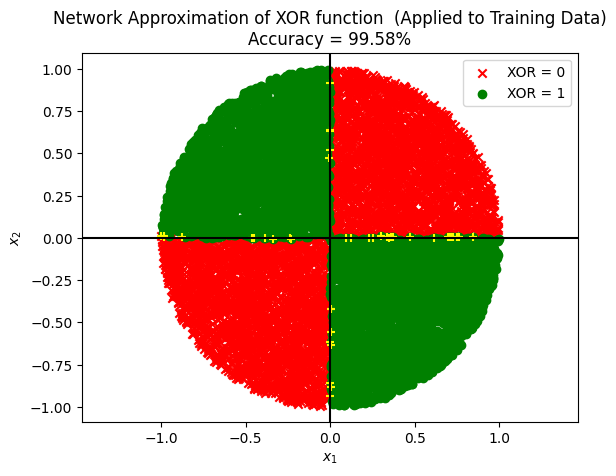

In [214]:
xor_thresh = 0.5 

xors_train_rounded = outputs.mean(axis=2).copy()
xors_train_rounded[xors_train_rounded <= xor_thresh] = 0
xors_train_rounded[xors_train_rounded > xor_thresh] = 1
xor_train_actual = np.array([xor(train_samples[:, i]) for i in range(train_samples.shape[1])])


mask_0 = np.isclose(xors_train_rounded, 0).squeeze()
mask_1 = np.isclose(xors_train_rounded, 1).squeeze()
plt.scatter(train_samples[0,mask_0], train_samples[1,mask_0], c='red', marker='x', label='XOR = 0')
plt.scatter(train_samples[0,mask_1], train_samples[1,mask_1], c='green', marker='o', label='XOR = 1')

mask_incorrect = (xors_train_rounded != xor_train_actual).squeeze()
plt.scatter(train_samples[0,mask_incorrect], train_samples[1,mask_incorrect], marker='+',c='yellow')
        
plt.axis('equal')
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

plt.title(f"Network Approximation of XOR function  (Applied to Training Data)\nAccuracy = {100 *(1 - sum(mask_incorrect)/num_samples_train)}%")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()


# Test XOR Approximation

100%|██████████| 1000/1000 [00:03<00:00, 325.07it/s]


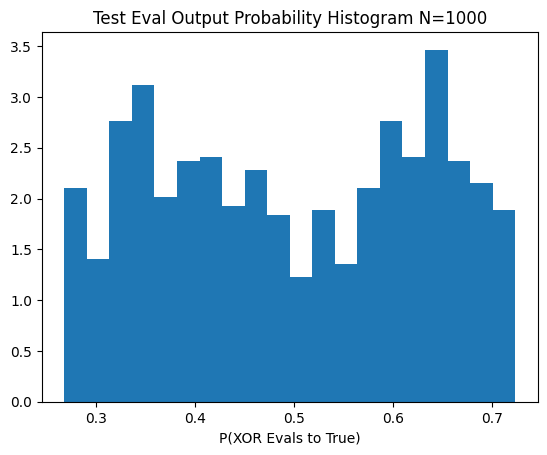

In [215]:
outputs_test = infer(test_samples, neurons, decoders, config)
#  (D x S) x (D x Y).T @ (D x S) ==> Y x 
plt.hist(outputs_test.mean(axis=2).T, 20, density=True)
plt.title(f"Test Eval Output Probability Histogram N={test_samples.shape[1]}")
plt.xlabel("P(XOR Evals to True)")
plt.show()

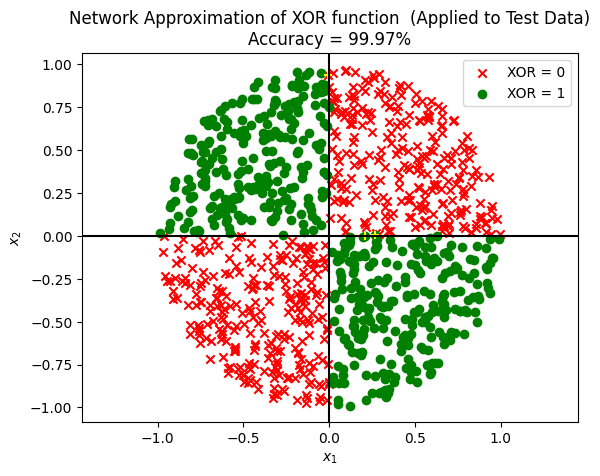

In [216]:
xor_thresh = 0.5 

xors_test_rounded = outputs_test.mean(axis=2).copy()
xors_test_rounded[xors_test_rounded <= xor_thresh] = 0
xors_test_rounded[xors_test_rounded > xor_thresh] = 1
xors_test_actual = np.array([xor(test_samples[:, i]) for i in range(test_samples.shape[1])])


mask_0 = np.isclose(xors_test_rounded, 0).squeeze()
mask_1 = np.isclose(xors_test_rounded, 1).squeeze()
plt.scatter(test_samples[0,mask_0], test_samples[1,mask_0], c='red', marker='x', label='XOR = 0')
plt.scatter(test_samples[0,mask_1], test_samples[1,mask_1], c='green', marker='o', label='XOR = 1')

mask_incorrect = (xors_test_rounded != xors_test_actual).squeeze()
plt.scatter(test_samples[0,mask_incorrect], test_samples[1,mask_incorrect], marker='+',c='yellow')
        
plt.axis('equal')
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

plt.title(f"Network Approximation of XOR function  (Applied to Test Data)\nAccuracy = {100 *(1 - sum(mask_incorrect)/num_samples_train)}%")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

# Layer-based Training + Test Errors

In [217]:
decoders_layer =[]
for idx_layer in tqdm.tqdm(range(config.depth)):
    layer_acts_train = activations.compute_activations(neurons, train_samples, config)
    decoders_layer.append(compute_decoders(layer_acts_train, xors_train, config))

100%|██████████| 50/50 [18:29<00:00, 22.19s/it]


In [ ]:
# for decoder in decoders:
# infer from decoder
#
accs_train = []
accs_test = []
xors_test_actual = np.array([xor(test_samples[:, i]) for i in range(num_samples_test)])
xor_train_actual = np.array([xor(train_samples[:, i]) for i in range(train_samples.shape[1])])

for idx_decoder, dec in enumerate(decoders):
    if idx_decoder > 0:
        # train accuracy 
        xor_est_train = dec @ activations_train[:idx_decoder].reshape(idx_decoder * num_neurons, num_samples_train)              
        xor_est_train[xor_est_train < .5] = 0
        xor_est_train[xor_est_train >= .5] = 1 
        accs_train.append(100 * sum(xor_est_train == xor_train_actual) / num_samples_train)

        # test accuracy
        xor_est_test = dec @ activations_test[:idx_decoder].reshape(idx_decoder * num_neurons, num_samples_test)
        xor_est_test[xor_est_test < .5] = 0
        xor_est_test[xor_est_test >= .5] = 1 
        accs_test.append(100 * sum(xor_est_test == xors_test_actual) / num_samples_test)

In [ ]:
len(accs_test), len(accs_train)

In [ ]:
plt.plot(accs_train, label="Train Classification Accuracy")
plt.plot(accs_test,  label='Test Classification Accuracy')
plt.xscale('log')
plt.title("Test and Training Accuracy")
plt.xlabel("Neuron Layers used to fit model")
plt.ylabel("Classification Accuracy on Test Set")
plt.legend()

# Correlations

In [ ]:
corrs_inter = np.zeros((depth-1,))
corrs_intra = np.zeros((depth-1,))

for idx_layer in range(1, depth-1):
    ccf_inter = np.corrcoef(activations_train[idx_layer-1,:,:], activations_train[idx_layer,:,:], )
    ccf_inter = ccf_inter - np.eye(ccf_inter.shape[0])

    ccf_intra = np.corrcoef(activations_train[idx_layer-1,:,:], activations_train[idx_layer,:,:], )
    ccf_intra = ccf_intra - np.eye(ccf_intra.shape[0])
    
    # zero out intra-layer correlations
    ccf_inter[0:num_neurons, 0:num_neurons] = 0
    ccf_inter[num_neurons:, num_neurons:] = 0

    ccf_intra[0:num_neurons, num_neurons:] = 0
    ccf_intra[num_neurons:, 0:num_neurons] = 0



    # correlations between layers
    corrs_inter[idx_layer] = np.max(np.abs(ccf_inter))
    corrs_intra[idx_layer] = np.max(np.abs(ccf_intra))
    # correaltions within layers 
    

# plt.imshow(ccf_intra, vmin=-1, vmax=1)
# plt.colorbar()
# for idx_layer in range(depth):
#     pass
plt.plot(corrs_inter, label='Inter-layer max correlation')
plt.plot(corrs_intra, label='Intra-layer max correlation')
plt.xscale('log')
plt.xlim([2, depth])
plt.xlabel('Layer')
plt.ylabel("Maximum Absolute Pairwise Correlation Over Batch")
plt.legend()

In [ ]:
plt.plot(100*corrs_inter, label='Inter-layer max correlation')
plt.plot(100*corrs_intra, label='Intra-layer max correlation')
# plt.xscale('log')
plt.xlim([2, depth])
plt.xlabel('Layer')
# plt.ylabel("Maximum Absolute Pairwise Correlation Over Batch")
plt.legend()

plt.plot(accs_train, label="Train Classification Accuracy")
plt.plot(accs_test,  label='Test Classification Accuracy')
plt.xscale('log')
plt.title("Test and Training Accuracy")
# plt.xlabel("Neuron Layers used to fit model")
# plt.ylabel("Classification Accuracy on Test Set")
plt.legend()